In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

Feature Engineering

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv("../data/train.csv")
X_train, X_test = train_test_split(data,test_size=0.2,random_state=42)

outlayers = [r for r in X_train.index if X_train.loc[r, 'SalePrice'] > 350000]
print(len(outlayers))
X_train.drop(outlayers, inplace=True)

43


In [5]:
Y_train = X_train.pop('SalePrice')
Y_test = X_test.pop('SalePrice')

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropNaHeavyColumns(BaseEstimator,TransformerMixin):
    def __init__(self,threshold:int = 0.6):
       self.drop_cols = []
       self.threshold = threshold

    def fit(self, X, y=None):
        self.drop_cols = [col for col in X if X[col].isna().sum()>=X.shape[0]*self.threshold]
        # print('drop_na',len(self.drop_cols))
        return self

    def transform(self, X:pd.DataFrame):
        X_transformed = X.copy()
        X_transformed.drop(columns=self.drop_cols,inplace=True)
        return X_transformed

In [7]:
class CustomImputer(BaseEstimator,TransformerMixin):
    def __init__(self, strategy:str = 'most_frequent'):
       self.imputer = None
       self.strategy = strategy

    def fit(self, X, y=None):
        X_copy = X.copy()
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.imputer.fit(X_copy)
        return self

    def transform(self, X:pd.DataFrame):
        X_transformed = X.copy()
        ret_val = pd.DataFrame(self.imputer.transform(X),columns=X_transformed.columns)

        return ret_val.astype(X_transformed.dtypes)

In [8]:
class ProportionEncoder():
    def __init__(self):
        self.dict = {}
        self.default_val = 0

    def fit(self, X:pd.DataFrame, y:pd.DataFrame):
        X = X.copy()
        X['target'] = y

        self.dict = {}
        cat_cols = [c for c in X.columns if X[c].dtype == 'object']

        for c in cat_cols:
            col_dict = {}
            self.dict[c] = X.groupby(c).agg({'target' : 'mean'}).to_dict()['target']

    def transform(self, X:pd.DataFrame):
        X = X.copy()
        cat_cols = [c for c in X.columns if X[c].dtype == 'object']
        
        for c in cat_cols:
            X[c] = X[c].map(self.dict[c])
            X[c] = X[c].fillna(self.default_val)
        
        return X

In [9]:
print(X_train[['PoolQC']].isna().sum())

enc = ProportionEncoder()
enc.fit(X_train,Y_train)
converted = enc.transform(X_train)
converted.dtypes


PoolQC    1120
dtype: int64


Id                 int64
MSSubClass         int64
MSZoning         float64
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType         float64
SaleCondition    float64
Length: 80, dtype: object

In [10]:
class CustomColumnTransformer(BaseEstimator,TransformerMixin):
    def __init__(self,threshold:int = 3):
       self.ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
       self.one_hot = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
       self.enc = ProportionEncoder()
       self.one_hot_cols = []
       self.ordinal_cols = []
       self.threshold = threshold

    def fit(self, X:pd.DataFrame, y=None):
        X_copy = X.copy()
        self.ordinal_cols = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique()>self.threshold]
        self.one_hot_cols = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique()<=self.threshold]
        # self.ordinal.fit(X_copy[self.ordinal_cols])
        self.enc.fit(X_copy[self.ordinal_cols],y)
        self.one_hot.fit(X_copy[self.one_hot_cols])
        return self

    def transform(self, X:pd.DataFrame):
        X_copy = X.copy()
        X_copy[self.ordinal_cols] = self.enc.transform(X_copy[self.ordinal_cols])#pd.DataFrame(self.ordinal.transform(X_copy[self.ordinal_cols]),columns=self.ordinal_cols)
        hot_cols = X_copy[self.one_hot_cols] 
        one_hot =  pd.DataFrame(self.one_hot.transform(hot_cols),columns=self.one_hot.get_feature_names_out())
        X_copy.drop(columns=self.one_hot_cols,inplace=True)
        return pd.concat([X_copy,one_hot],axis=1)


In [11]:
class Scaler(BaseEstimator,TransformerMixin):
    def __init__(self, scaler = StandardScaler()):
        self.scaler = scaler
        self.cat_cols = []

    def fit(self, X:pd.DataFrame, y=None):
        if self.scaler == None:
            return self
        self.cat_cols = [c for c in X if X[c].dtype != 'object']
        self.scaler.fit(X[self.cat_cols].copy())
        return self

    def transform(self, X):
        X_copy = X.copy()
        if self.scaler == None:
            return X_copy
        X_copy[self.cat_cols] = pd.DataFrame(self.scaler.transform(X_copy[self.cat_cols]),columns=self.cat_cols)
        return X_copy

Feature Selection

In [12]:
class RFE(BaseEstimator,TransformerMixin):
    def __init__(self, scaler = StandardScaler()):
       self.scaler = scaler

    def fit(self, X:pd.DataFrame, y=None):
        self.scaler.fit(X.copy())
        return self

    def transform(self, X):
        X_copy = X.copy()
        return self.scaler.transform(X_copy)    

In [13]:
class CorrelationFilter(BaseEstimator,TransformerMixin):
    def __init__(self, threshold:int = 0.7):
        self.threshold = threshold
        self.features_to_drop = []

    def fit(self, X:pd.DataFrame, y):
        X_copy = X.copy()
        corr_matrix = X_copy.corr().abs()
        high_corr_pairs = []

        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > self.threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))


        features_to_drop = []
        for feat1, feat2, _ in high_corr_pairs:
            if abs(X[feat1].corr(y)) < abs(X[feat2].corr(y)):
                features_to_drop.append(feat1)
            else:
                features_to_drop.append(feat2)
        self.features_to_drop = features_to_drop
        print('Dropped Features',len(self.features_to_drop))
        return self

    def transform(self, X:pd.DataFrame):
        X_copy = X.copy()
        return X_copy.drop(columns=self.features_to_drop)

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocess(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.cat_cols = ['MSZoning', 'Street', 'LandContour', 'Utilities','LandSlope', 'Condition1' ,'Condition2', 'RoofMatl', 'GarageQual', 'GarageCond', 'Heating', 'Electrical', 'Functional', 'PavedDrive', 'SaleType']
        self.num_cols = ['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

    def fit(self, X, y=None):
        return self

    def transform(self, X:pd.DataFrame):
        X_transformed = X.copy()
        X_transformed.drop(columns=self.cat_cols,inplace=True)
        X_transformed.drop(columns=self.num_cols,inplace=True)
        return X_transformed

Training

In [33]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline(steps=[
    ('custrom_drop', CustomPreprocess()),
    ('dropna', DropNaHeavyColumns(0.5)),
    ('imputer', CustomImputer()),
    ('cat2num', CustomColumnTransformer(threshold=30)),
    ('Scaler', Scaler(RobustScaler())),
    ('corr_filter', CorrelationFilter(0.7)),
    ('Model', Ridge(alpha=100))
])

In [45]:
kfold = KFold(n_splits=5, shuffle=True, random_state=40)

scalers = [
    MinMaxScaler(),
    RobustScaler(),
    None
]


param_grid = {
    # 'cat2num__threshold': [3,7,10,20,30],
    # 'Scaler__scaler': scalers,
    # 'dropna__threshold' : [0.4,0.5,0.6,0.7,0.8,1], 
    # 'corr_filter__threshold': [0.6,0.7,0.8,0.9,0.95,0.98],
    'Model__alpha' : [10,40, 60, 100, 500, 1000]
}

scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

grid_search = GridSearchCV(
    pipeline,
    cv=kfold,
    scoring=scoring,
    return_train_score=True,
    refit='r2',
    verbose=0,
    param_grid=param_grid
)

In [46]:
grid_search.fit(X_train,Y_train)

Dropped Features 30
Dropped Features 30
Dropped Features 27


c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Dropped Features 29
Dropped Features 29
Dropped Features 30
Dropped Features 30
Dropped Features 27


c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Dropped Features 29
Dropped Features 29
Dropped Features 30
Dropped Features 30
Dropped Features 27


c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Dropped Features 29
Dropped Features 29
Dropped Features 30
Dropped Features 30
Dropped Features 27


c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Dropped Features 29
Dropped Features 29
Dropped Features 30
Dropped Features 30
Dropped Features 27


c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Dropped Features 29
Dropped Features 29
Dropped Features 30
Dropped Features 30
Dropped Features 27


c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Dropped Features 29
Dropped Features 29
Dropped Features 28


GridSearchCV(cv=KFold(n_splits=5, random_state=40, shuffle=True),
             estimator=Pipeline(steps=[('custrom_drop', CustomPreprocess()),
                                       ('dropna',
                                        DropNaHeavyColumns(threshold=0.5)),
                                       ('imputer', CustomImputer()),
                                       ('cat2num',
                                        CustomColumnTransformer(threshold=30)),
                                       ('Scaler',
                                        Scaler(scaler=RobustScaler())),
                                       ('corr_filter', CorrelationFilter()),
                                       ('Model', Ridge(alpha=100))]),
             param_grid={'Model__alpha': [10, 40, 60, 100, 500, 1000]},
             refit='r2', return_train_score=True,
             scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2',
                      'rmse': 'neg_root_mean_squared_error'})

In [47]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best parameters: {'Model__alpha': 10}
Best cross-validation score: 0.8164


In [48]:
results = pd.DataFrame(grid_search.cv_results_)

In [49]:
results = results.sort_values(by='mean_test_rmse', ascending=False)

In [50]:
cv_results =  results[['params','mean_test_mae','mean_train_mae','mean_test_r2','mean_train_r2','mean_test_rmse','mean_train_rmse']]

In [51]:
# for c in cv_results.index:
#     print(cv_results.iloc[c].iloc[0],cv_results.iloc[c].iloc[1],cv_results.iloc[c].iloc[2],cv_results.iloc[c].iloc[3],cv_results.iloc[c].iloc[4],cv_results.iloc[c].iloc[5],cv_results.iloc[c].iloc[6])

cv_results

,params,mean_test_mae,mean_train_mae,mean_test_r2,mean_train_r2,mean_test_rmse,mean_train_rmse
0,{'Model__alpha': 10},-16008.043991,-13966.654296,0.816380,0.882715,-25039.188150,-20401.325758
1,{'Model__alpha': 40},-16293.520203,-14828.694915,0.812066,0.866131,-25311.826295,-21794.285698
2,{'Model__alpha': 60},-16475.139281,-15190.650707,0.809608,0.859086,-25492.552044,-22359.900805
3,{'Model__alpha': 100},-16783.845469,-15709.446758,0.805518,0.848647,-25801.548370,-23173.368198
4,{'Model__alpha': 500},-18925.890284,-18475.456121,0.769974,0.792673,-28293.186046,-27130.815197
5,{'Model__alpha': 1000},-21381.516052,-21143.799570,0.726155,0.741371,-30987.329397,-30308.566014


In [41]:
grid_search.best_estimator_

Pipeline(steps=[('custrom_drop', CustomPreprocess()),
                ('dropna', DropNaHeavyColumns(threshold=0.5)),
                ('imputer', CustomImputer()),
                ('cat2num', CustomColumnTransformer(threshold=30)),
                ('Scaler', Scaler(scaler=RobustScaler())),
                ('corr_filter', CorrelationFilter()),
                ('Model', Ridge(alpha=100))])

In [42]:
from sklearn.model_selection import cross_validate

scoring = {
    'mae': 'neg_mean_absolute_error',
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

# p = Pipeline(pipeline.steps)

results = cross_validate(pipeline, X_train, Y_train, cv=kfold, scoring=scoring, return_train_score=True)

train_rmse = -1*np.mean(results['train_rmse'])
test_rmse = -1*np.mean(results['test_rmse'])

print(f"train rmse: {train_rmse:.4f}")
print(f"test rmse: {test_rmse:.4f}")


train_r2 = np.mean(results['train_r2'])
test_r2 = np.mean(results['test_r2'])

print(f"train r2: {(train_r2):.4f}")
print(f"test r2: {(test_r2):.4f}")

train_mae = -1*np.mean(results['train_mae'])
test_mae = -1*np.mean(results['test_mae'])

print(f"train mae: {train_mae:.4f}")
print(f"test mae: {test_mae:.4f}")


Dropped Features 30
Dropped Features 30
Dropped Features 27


c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Achi\Desktop\ML01_House-Prices\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Dropped Features 29
Dropped Features 29
train rmse: 23173.3682
test rmse: 25801.5484
train r2: 0.8486
test r2: 0.8055
train mae: 15709.4468
test mae: 16783.8455


Upload to Dagshub

In [ ]:
# import dagshub
# dagshub.init(repo_owner='azhgh22', repo_name='ML01_House-Prices', mlflow=True)

Accessing as azhgh22

Initialized MLflow to track repo "azhgh22/ML01_House-Prices"

Repository azhgh22/ML01_House-Prices initialized!

C:\Users\Achi\AppData\Local\Temp\ipykernel_4756\4207582585.py:34: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


Dropped Features 28


2025/04/09 08:25:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run1 at: https://dagshub.com/azhgh22/ML01_House-Prices.mlflow/#/experiments/3/runs/49310e44b9fa4de099ef02ae1e0e2074
🧪 View experiment at: https://dagshub.com/azhgh22/ML01_House-Prices.mlflow/#/experiments/3


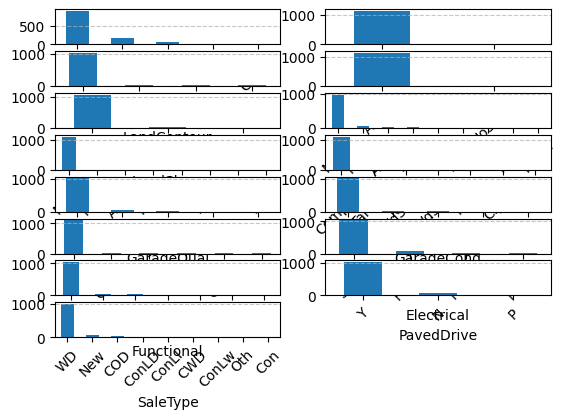

In [ ]:
# import matplotlib.pyplot as plt
# import mlflow
# mlflow.set_experiment("Experiment 3: Linear Regression")
# with mlflow.start_run(run_name="run1"):
#     mlflow.log_params({
#         'CustomPreprocess' : 'drop features, that have low varianve',
#         'droped features threshold': 'droped (NA count) >= (row count)*0.5',
#         'Imputer' : 'fill with mode',
#         'Cat2num' : 'if feature have 30+ categorical value fill with mean of target group by this categorical value, else use OneHotEncoding',
#         'Correlation filter thresholds' : 0.7,
#         'Scaler' : 'RobustScaler',
#         'kfold splits': 5,
#         'random_state': 42,
#         'regularization alpha' : 100, 
#         'ModelType' : 'LinearRegression + Regularization',
#         'Score' : 'neg_root_mean_squared_error',
#     })
#     mlflow.log_metrics({
#         'train_rmse': train_rmse,
#         'test_rmse' : test_rmse,
#         'train_r2' : train_r2,
#         'test_r2' : test_r2,
#         'train_mae' : train_mae,
#         'test_mae' : test_mae
#     })

#     cat_cols = CustomPreprocess().cat_cols

#     for i, c in enumerate(cat_cols):
#         plt.subplot(9, 2, i+1)
#         X_train[c].value_counts().plot(kind='bar')
#         plt.xticks(rotation=45)
#         plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.tight_layout()
#     plt.savefig("low_var_features.png")
#     mlflow.log_artifact("low_var_features.png")
#     mlflow.sklearn.log_model(pipeline.fit(X_train,Y_train),'LinregressionPipeline')
    
#     mlflow.end_run()